# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


Для корректного разбиения выборки найдём оптимальный параметр `stratify`, чтобы равномерно распределить целевую переменную. Для этого воспользуемся формулой Стёрджесса: $k = \lfloor \log2(n) \rfloor + 1$.

In [151]:
k = int(np.log2(len(df))) + 1

Посмотрим на распределение целевой переменной.

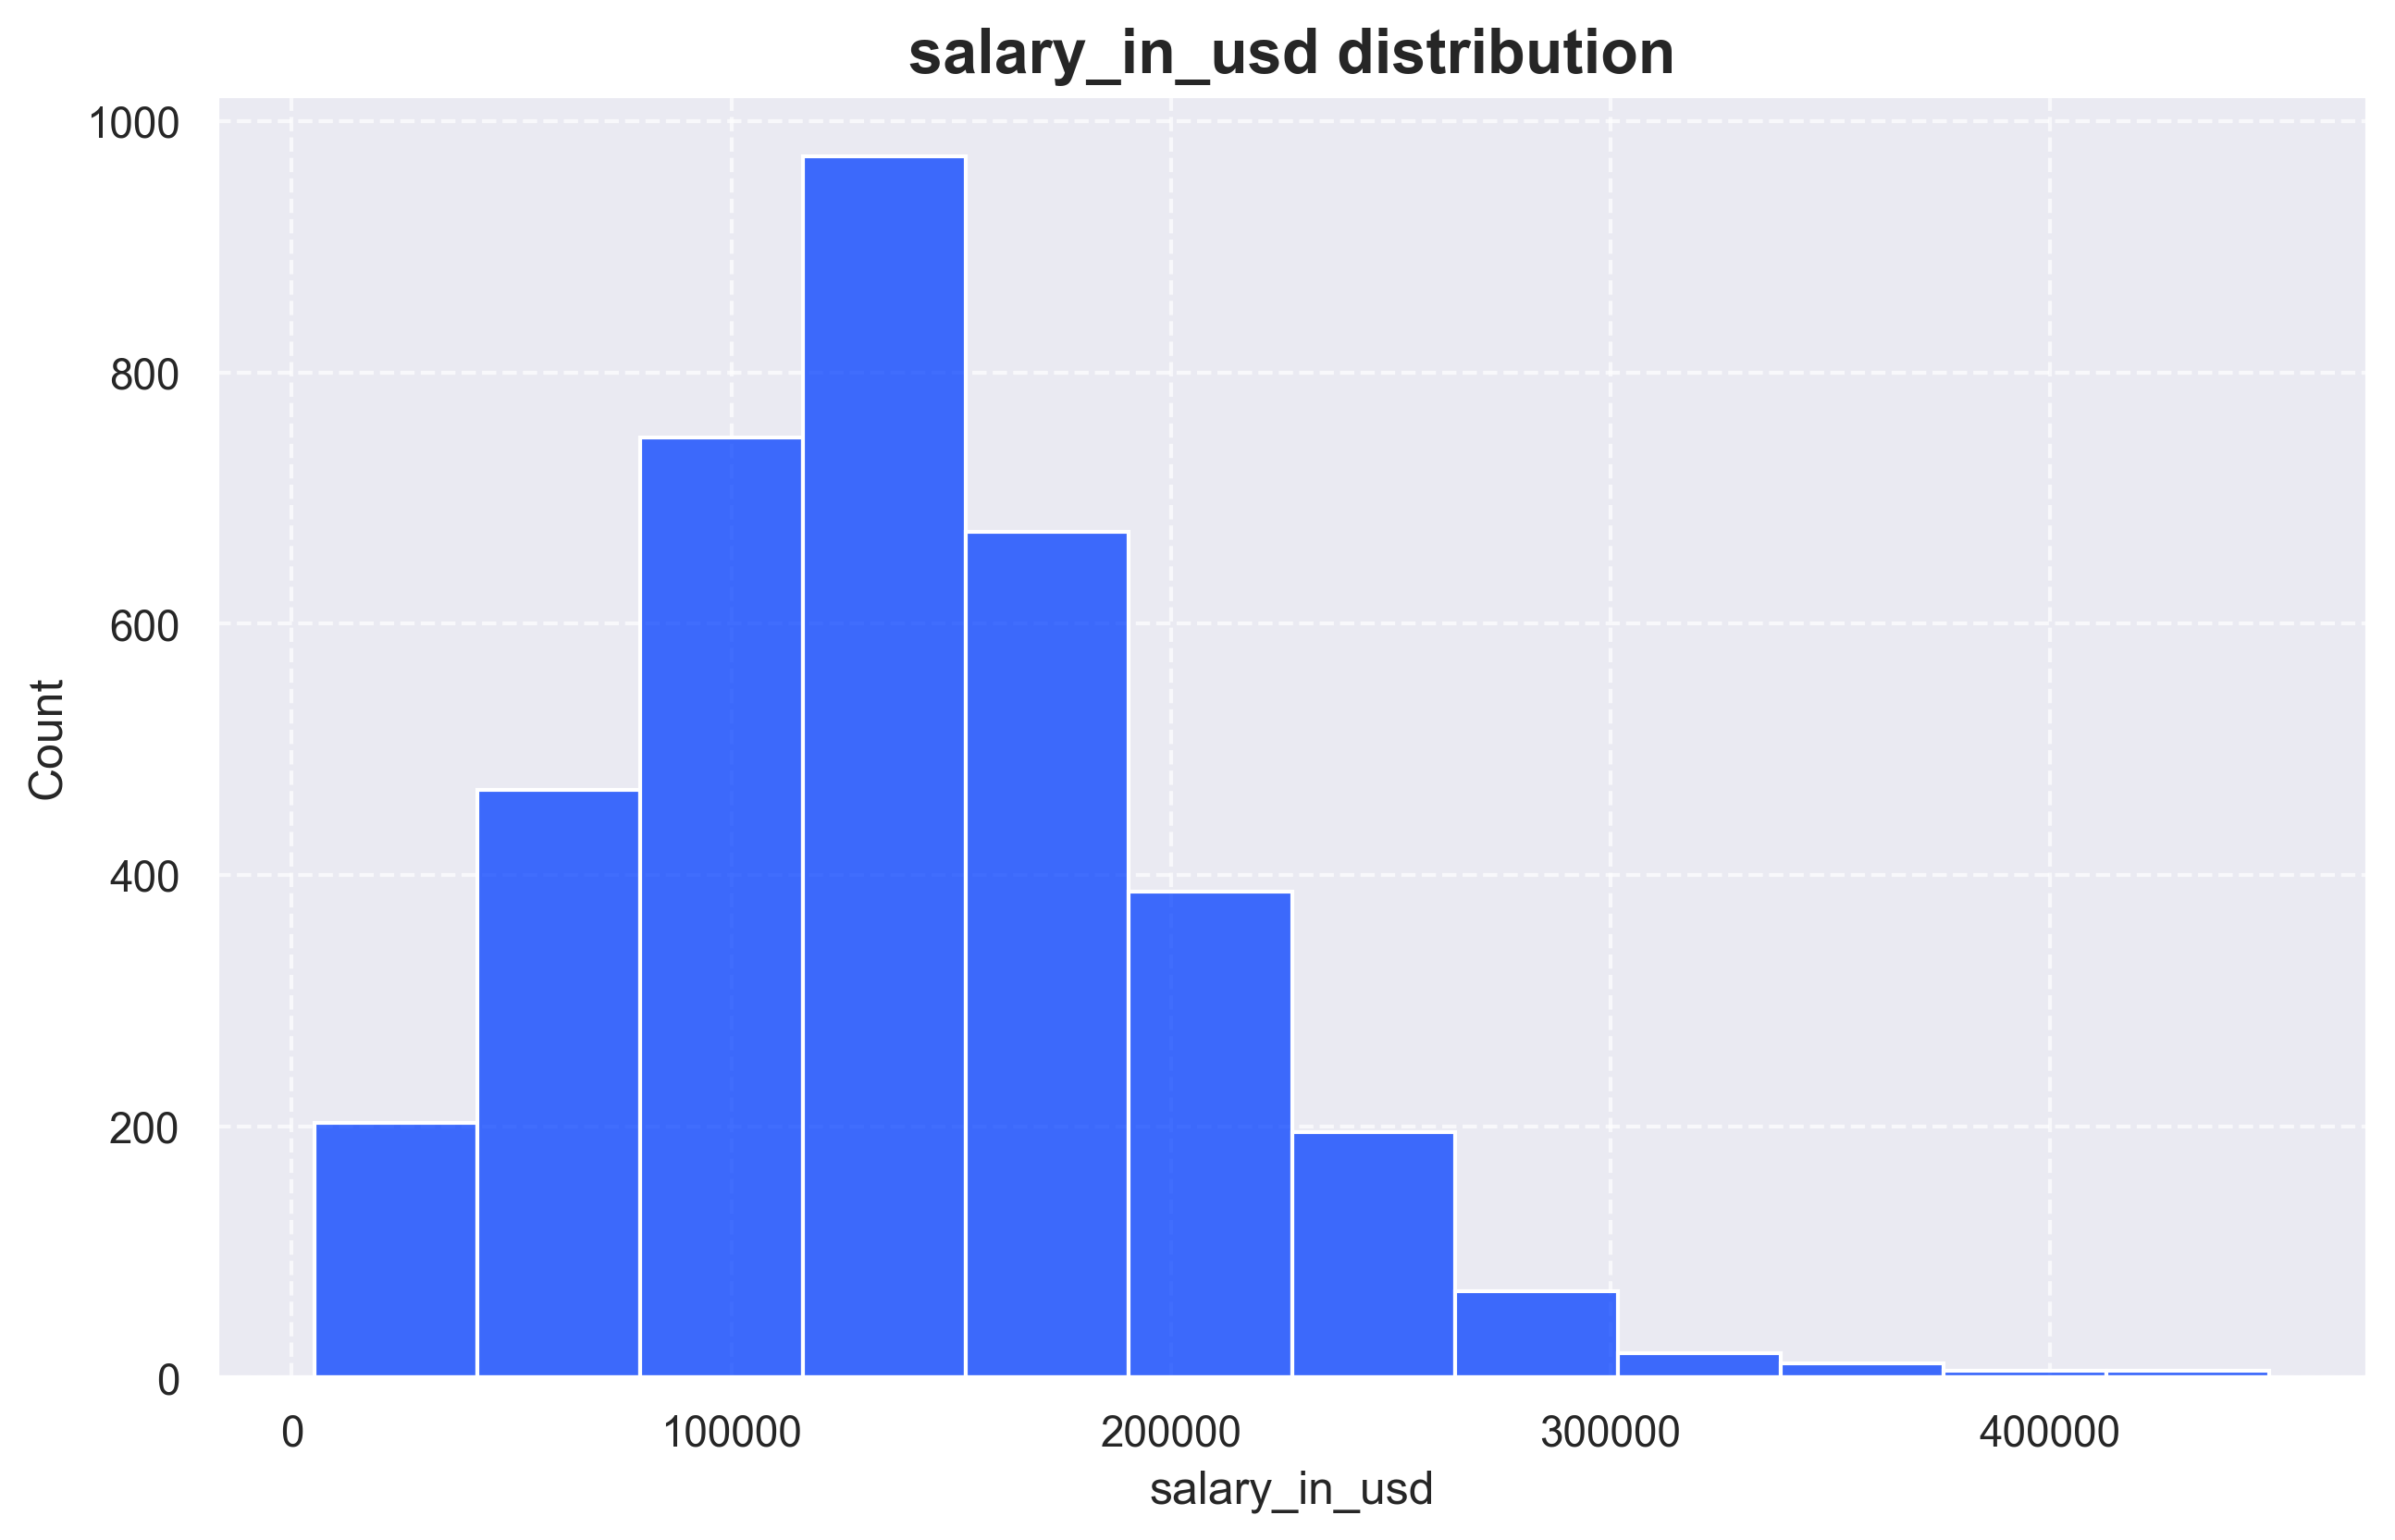

In [152]:
sns.set_theme(palette="bright")

plt.figure(figsize=(10, 6), dpi=300)
sns.histplot(df['salary_in_usd'], bins=k)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('salary_in_usd distribution', fontsize=16, fontweight='bold')
plt.show()

In [153]:
from sklearn.preprocessing import KBinsDiscretizer

df['salary_in_usd_stratify'] = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile').fit_transform(df[['salary_in_usd']])[:, 0]

In [154]:
df['salary_in_usd_stratify'].value_counts()

salary_in_usd_stratify
9.0     357
7.0     340
11.0    337
3.0     329
2.0     325
4.0     311
0.0     310
5.0     297
10.0    289
8.0     289
1.0     288
6.0     283
Name: count, dtype: int64

Удалим из датафрейма столбцы, которые влияют на лик данных. Это столбец зарпалаты `salary` и столбец валюты `salary_currency` - оставим только 1 столбец с зарпалатами в долларах `salary_in_usd`.

Разделим датафрейм на признаки и целевую переменную, после чего разделим выборку на тренировочую и промежуточную (валидационная и тестовая).

In [155]:
from sklearn.model_selection import train_test_split

df = df.drop(columns=["salary", "salary_currency"])
X = df.drop(columns=["salary_in_usd"])
y = df["salary_in_usd"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, random_state=42, stratify=df['salary_in_usd_stratify'])

Для промежуточной выборки посчитаем значение стратификации и разделим эту выборку на валидационную и тренировочную.

In [156]:
k_temp = int(np.log2(len(y_temp))) + 1
X_temp['salary_in_usd_stratify'] = KBinsDiscretizer(n_bins=k_temp, encode='ordinal', strategy='quantile').fit_transform(X_temp[["salary_in_usd_stratify"]])[:, 0]

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=X_temp["salary_in_usd_stratify"])

Удалим вспомогательный столбец для разделения выборки `salary_in_usd_stratify`.

In [157]:
X_train_base = X_train.drop(columns=["salary_in_usd_stratify"])
X_val_base = X_val.drop(columns=["salary_in_usd_stratify"])
X_test_base = X_test.drop(columns=["salary_in_usd_stratify"])

In [158]:
print("Number of objects in samples:")
print(f"Train:      {len(X_train_base)}")
print(f"Validation: {len(X_val_base)}")
print(f"Test:       {len(X_test_base)}")

Number of objects in samples:
Train:      3004
Validation: 375
Test:       376


## Задание 2 (0.5 балла) Линейная модель

*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns and parse them to list
categorical_features = X_train_base.select_dtypes(include=["object"]).columns.tolist()

# Fit encoder
# `handle_unknown` is for prevention if there are unknown categories in validation or test sample
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder.fit(X_train_base[categorical_features])

# Encodin
X_train_encoded = encoder.transform(X_train_base[categorical_features])
X_val_encoded = encoder.transform(X_val_base[categorical_features])
X_test_encoded = encoder.transform(X_test_base[categorical_features])

# Convert encoded data to DataFrame with name of columns
encoded_columns = encoder.get_feature_names_out(categorical_features)

X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_columns, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

# Concatination of categorical and numeric features
numeric_columns = X_train_base.select_dtypes(exclude=["object"]).columns.tolist()

X_train = pd.concat([X_train_base[numeric_columns], X_train_encoded], axis=1)
X_val = pd.concat([X_val_base[numeric_columns], X_val_encoded], axis=1)
X_test = pd.concat([X_test_base[numeric_columns], X_test_encoded], axis=1)

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict
y_pred = linreg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'MAPE: {mape:.4f}')
print(f'RMSE: {rmse:.4f}')

MAPE: 0.3396
RMSE: 46002.8137


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [160]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error
import random 

random.seed(42)

param_dist = {
    'max_depth': np.arange(1, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 501, 50),
    'gamma': np.linspace(0, 1, 10)
}

n_iter = 100
min_mse = float('inf')
best_params = None

for _ in range(n_iter):
    params = {
        'max_depth': random.choice(param_dist['max_depth']),
        'learning_rate': random.choice(param_dist['learning_rate']),
        'n_estimators': random.choice(param_dist['n_estimators']),
        'gamma': random.choice(param_dist['gamma']),
    }

    xgb_reg = XGBRegressor(**params)
    xgb_reg.fit(X_train, y_train)

    y_pred = xgb_reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if mse < min_mse:
        min_mse = mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Validation MSE: {min_mse:.4f}")

Best params: {'max_depth': np.int64(3), 'learning_rate': np.float64(0.23555555555555557), 'n_estimators': np.int64(450), 'gamma': np.float64(0.4444444444444444)}
Validation MSE: 2131549440.0000


In [161]:
import time

xgb_reg = XGBRegressor(**best_params)
start_fit = time.time()
xgb_reg.fit(X_train, y_train)
end_fit = time.time()

print(f"Fitting time: {(end_fit - start_fit):.4f}")

start_pred = time.time()
y_pred = xgb_reg.predict(X_test)
end_pred = time.time()

print(f"Prediction time: {(end_pred - start_pred):.4f}\n")

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'MAPE: {mape:.4f}')
print(f'RMSE: {rmse:.4f}')

Fitting time: 0.4315
Prediction time: 0.0072

MAPE: 0.3437
RMSE: 46833.5547


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [162]:
from catboost import CatBoostRegressor

param_dist = {
    'depth': np.arange(1, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': np.arange(50, 501, 50)
}

n_iter = 100
min_mse = float('inf')
best_params = None

for _ in range(n_iter):
    params = {
        'depth': random.choice(param_dist['depth']),
        'learning_rate': random.choice(param_dist['learning_rate']),
        'iterations': random.choice(param_dist['iterations'])
    }

    catboost_reg = CatBoostRegressor(**params)
    catboost_reg.fit(X_train, y_train, verbose=False)

    y_pred = catboost_reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if mse < min_mse:
        min_mse = mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Validation MSE: {min_mse:.4f}")

Best params: {'depth': np.int64(3), 'learning_rate': np.float64(0.23555555555555557), 'iterations': np.int64(150)}
Validation MSE: 2140414020.8751


In [163]:
total_fit_time = 0
total_predication_time = 0
mape_mean = 0
rmse_mean = 0

n_iter = 20

for _ in range(n_iter):
    catboost_reg = CatBoostRegressor(**best_params)
    start_fit = time.time()
    catboost_reg.fit(X_train, y_train, verbose=False)
    end_fit = time.time()

    start_pred = time.time()
    y_pred = catboost_reg.predict(X_test)
    end_pred = time.time()

    total_fit_time += end_fit - start_fit
    total_predication_time += end_pred - start_pred

    mape_mean += mean_absolute_percentage_error(y_test, y_pred)
    rmse_mean += root_mean_squared_error(y_test, y_pred)

print(f"Fitting time: {(total_fit_time / n_iter):.4f}")
print(f"Prediction time: {(total_predication_time / n_iter):.4f}\n")

print(f'MAPE: {(mape_mean / n_iter):.4f}')
print(f'RMSE: {(rmse_mean / n_iter):.4f}')

Fitting time: 0.0678
Prediction time: 0.0026

MAPE: 0.3546
RMSE: 47041.1944


Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [164]:
X_train_base.head(3)

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
1731,2023,SE,FT,Data Engineer,US,0,US,M
2814,2022,MI,FT,Data Operations Engineer,US,100,US,M
2865,2022,SE,FT,Data Scientist,US,100,US,M


In [165]:
X_train_base.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [166]:
cat_features = df.select_dtypes(include=["object"]).columns.to_list()
cat_features

['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'company_location',
 'company_size']

In [167]:
from catboost import Pool

param_dist = {
    'depth': np.arange(1, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'iterations': np.arange(50, 501, 50)
}

n_iter = 100
min_mse = float('inf')
best_params = None

for _ in range(n_iter):
    params = {
        'depth': random.choice(param_dist['depth']),
        'learning_rate': random.choice(param_dist['learning_rate']),
        'iterations': random.choice(param_dist['iterations'])
    }

    train_pool = Pool(X_train_base, y_train, cat_features=cat_features)

    catboost_reg = CatBoostRegressor(**params)
    catboost_reg.fit(train_pool, verbose=False)

    y_pred = catboost_reg.predict(X_val_base)
    mse = mean_squared_error(y_val, y_pred)

    if mse < min_mse:
        min_mse = mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Validation MSE: {min_mse:.4f}")

Best params: {'depth': np.int64(4), 'learning_rate': np.float64(0.10666666666666666), 'iterations': np.int64(250)}
Validation MSE: 2154835948.1662


In [168]:
total_fit_time = 0
total_predication_time = 0
mape_mean = 0
rmse_mean = 0

n_iter = 20

for _ in range(n_iter):
    catboost_reg = CatBoostRegressor(**best_params)
    train_pool = Pool(X_train_base, y_train, cat_features=cat_features)
    start_fit = time.time()
    catboost_reg.fit(train_pool, verbose=False)
    end_fit = time.time()

    start_pred = time.time()
    y_pred = catboost_reg.predict(X_test_base)
    end_pred = time.time()

    total_fit_time += end_fit - start_fit
    total_predication_time += end_pred - start_pred

    mape_mean += mean_absolute_percentage_error(y_test, y_pred)
    rmse_mean += root_mean_squared_error(y_test, y_pred)

print(f"Fitting time: {(total_fit_time / n_iter):.4f}")
print(f"Prediction time: {(total_predication_time / n_iter):.4f}\n")

print(f'MAPE: {(mape_mean / n_iter):.4f}')
print(f'RMSE: {(rmse_mean / n_iter):.4f}')

Fitting time: 0.3068
Prediction time: 0.0014

MAPE: 0.3508
RMSE: 46191.3138


**Ответ:** Получились следующие значения (могут немного отличаться из-за рандома, но всё же должны быть примерно такие же):

Model | Fitting time | Prediction time | MAPE | RMSE
----------|--------------|-----------------|------|-----
CatBoost | 0.0678 | 0.0026 | 0.3546 | 47041.1944
CatBoost with Pool| 0.3068 | 0.0014 | 0.3508 | 46191.3138

Время обучения с Pool стало сильно больше - почти в 5 раза, но время предсказания сократилось в 2 раза.

Качество при использовании Pool стало немного лучше, как на MAPE, так и на RMSE.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [169]:
from lightgbm import LGBMRegressor

param_dist = {
    'max_depth': np.arange(1, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 501, 50)
}

n_iter = 10
min_mse = float('inf')
best_params = None

for _ in range(n_iter):
    params = {
        'max_depth': random.choice(param_dist['max_depth']),
        'learning_rate': random.choice(param_dist['learning_rate']),
        'n_estimators': random.choice(param_dist['n_estimators'])
    }

    lgbm_reg = LGBMRegressor(**params, force_row_wise=True, verbose=0)
    lgbm_reg.fit(X_train, y_train)

    y_pred = lgbm_reg.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)

    if mse < min_mse:
        min_mse = mse
        best_params = params

print(f"Best params: {best_params}")
print(f"Validation MSE: {min_mse:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [170]:
total_fit_time = 0
total_predication_time = 0
mape_mean = 0
rmse_mean = 0

n_iter = 20

for _ in range(n_iter):
    lgbm_reg = LGBMRegressor(**params, force_row_wise=True, verbose=0)
    start_fit = time.time()
    lgbm_reg.fit(X_train, y_train)
    end_fit = time.time()

    start_pred = time.time()
    y_pred = lgbm_reg.predict(X_test)
    end_pred = time.time()

    total_fit_time += end_fit - start_fit
    total_predication_time += end_pred - start_pred

    mape_mean += mean_absolute_percentage_error(y_test, y_pred)
    rmse_mean += root_mean_squared_error(y_test, y_pred)

print(f"Fitting time: {(total_fit_time / n_iter):.4f}")
print(f"Prediction time: {(total_predication_time / n_iter):.4f}\n")

print(f'MAPE: {(mape_mean / n_iter):.4f}')
print(f'RMSE: {(rmse_mean / n_iter):.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** 

Model | Fitting time | Prediction time | MAPE | RMSE
----------|--------------|-----------------|------|-----
XGBoost | 0.4315 | 0.0072 | 0.3437 | 46833.5547
CatBoost | 0.0678 | 0.0026 | 0.3546 | 47041.1944
Pool CatBoost | 0.3068 | 0.0014 | 0.3508 | 46191.3138
LightGBM | 0.0423 | 0.0013 | 0.3632 | 47299.7541

Все рзультаты по качеству оказались практически одинаковые. Можно выделить по метрике MAPE XGBoost, который справился на чуть-чуть лучше, а также Pool CatBoost на RMSE, который как раз-таки и предназначен для работы с категориальными признаками. Хуже всех (но совсем на капельку) оказался LightGBM.

Быстрее всех обучился LightGBM, а вот XGBoost и Pool CatBoost показали скорость сильно хуже остальных - соотвественно в 6 и 4 раза медленнее, чем CatBoost, который почти на равне с LightGBM. LightGBM использует многопточность, а также строит деревья по принципу расширения наилучшего листа, из-за чего строится меньше дервеьев, чем при классическом подходе.

Также LightGBM показал быструю скорость предсказания. Остальные модели справились примерно так же, только XGBoost опять-таки прогнозировал медленнее - аж в 5 раза.

### Гиперпараметры:

**XGBoost:**
- max_depth = 3
- learning_rate = 0.236
- n_estimators = 450
- gamma = 0.444

**CatBoost:**
- depth = 3
- learning_rate = 0.236
- iterations = 150

**Pool Catboost:**
- depth = 4
- learning_rate = 0.107
- iterations = 250

**LightGBM:**
- max_depth = 3
- learning_rate = 0.236
- n_estimators = 50

Глубина обучения и темп обучения у большинства моделей практически одинаковые, равные 3 и 0.236 соответственно. Выделяется CatBoost с использованием Pool, у которого глубина почти такая же, но темп обучения в 2 раза меньше - скорее всего, это потому что у него было сильно меньше признаков, а также потому, что он более приспособлен работать с категориальными признаками.

Количество итераций у всех моделей разное. У LightGBM меньше всего деревьев, это компенсируется скоростью обучения и предсказания.
В XGBoost больше всего деревьев, поэтому он долго обучается, зато это компенсирует небольшую глубину деревьев.

В CatBoost меньше итераций в 3 раза. Это говорит о том, что модель лучше сходится. CatBoost с Pool необходимо больше итераций, скорее всего, потому что он улавливает более сложные категориальные зависимости, а не просто признаки, закодированные с помощью OHE.

### Вывод:
XGBoost показал точный результат, но он медленный - если в задаче необходима именно точность, то лучше выбрать эту модель. Если бы данных было гораздо больше, стоило бы исопльзовать LightGBM, потому что он бы быстрее их обработал. Но на мой взгляд, для данной задачи лучше всего оказался CatBoost (особо без разницы: с Pool или без), как промежуточный вариант между двумя другими. 

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [171]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
# ratings = pd.read_excel("sample_matrix.xlsx")
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [172]:
ratings_T = ratings.T
ratings_T.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.0,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.0
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [173]:
ratings_T = ratings_T.drop("user", axis=0)
ratings_T.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [174]:
ratings_T = ratings_T.fillna(value=0)
ratings_T.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.043529,0.000000,0.0,0.0,0.093398,0.017621,...,0.000000,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.000000
radiohead,0.020417,0.184962,0.000000,0.0,0.086281,0.006322,0.0,0.0,0.000000,0.019156,...,0.017735,0.0,0.000000,0.000000,0.011187,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.024561,0.028635,0.0,0.034590,0.000000,0.0,0.0,0.000000,0.013349,...,0.121344,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.027893


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [175]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=5, random_state=42)
clusters = model.fit_predict(ratings_T)

ratings_T["cluster"] = clusters

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [176]:
cluster_sizes = ratings_T["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0    115
1      1
2      1
3    882
4      1
Name: count, dtype: int64

**Ответ:** Кластеризация получилась плохой, потому что в трёх кластерах по одному объекту, а в одном почти все остальные. Это произошло, потому что KMeans не смог найти чёткого разделения на 5 кластеров и собрал бОльшую часть объектов в один кластер. Это связано в данной выборке с тем, что есть много нулей, данные не были нормализованы, количество кластеров подобрано неверно.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [177]:
single_clusters = cluster_sizes[cluster_sizes == 1].index

single_artists = ratings_T[ratings_T["cluster"].isin(single_clusters)].index.to_list()

print("Artists in cluster with size 1:")
for artist in single_artists:
    print(artist)

Artists in cluster with size 1:
the beatles
niИ
日dir en grey


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [178]:
users_count = ratings_T.shape[1]
listeners_count = (ratings_T > 0).sum(axis=1)
fraction_listeners = listeners_count / users_count

mean_fraction_per_artist = ratings_T.replace(0, np.nan).mean(axis=1, skipna=True)

artist_stats = pd.DataFrame({
    'fraction_listeners': fraction_listeners,
    'listeners_count': listeners_count,
    'mean_fraction_per_artist': mean_fraction_per_artist
})

artist_stats.loc[artist_stats.index.str.contains("the beatles")]

,fraction_listeners,listeners_count,mean_fraction_per_artist
the beatles,0.334333,1672,0.057323


In [179]:
artist_stats.sort_values(by='fraction_listeners')[::-1].head(5)

,fraction_listeners,listeners_count,mean_fraction_per_artist
the beatles,0.334333,1672,0.057323
radiohead,0.277744,1389,0.042661
deathcab for cutie,0.186163,931,0.035141
coldplay,0.168166,841,0.035852
modest mouse,0.162767,814,0.036095


**Ответ:** The Beatles выделяются большим количеством прослушивателей - у них почти в 2 раза больше фанатов, чем у ближайших самых прослшуиваемых артистов, лишь Radiohead имеет также неплохую долю слушателей.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [180]:
from sklearn.preprocessing import normalize

ratings_T = ratings_T.drop(columns=['cluster'])

ratings_normalized = pd.DataFrame(
    data=normalize(ratings_T, norm='l2', axis=1),
    index=ratings_T.index,
    columns=ratings_T.columns
)

ratings_normalized.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [181]:
model = KMeans(n_clusters=5, random_state=42)
model.fit(ratings_normalized.values)

clusters = model.predict(ratings_normalized.values)
ratings_normalized["cluster"] = clusters

cluster_sizes = ratings_normalized["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0     79
1    162
2    133
3    140
4    486
Name: count, dtype: int64

**Ответ** Так стало сильно лучше. Теперь нет кластеров с одним объектом и выделяющихся кластеров, содержащих бОльшую часть объектов. Значения примерно расномерно распределены. Проблема очень ужасных единичных кластеров исправлена, поэтому можем назвать такую кластеризацию полезной.

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [182]:
from scipy.spatial.distance import cosine

centroids = model.cluster_centers_

for cluster in range(len(cluster_sizes)):
    cluster_artists = ratings_normalized.index[model.labels_ == cluster]

    cluster_vector = ratings_normalized.drop(columns=["cluster"]).loc[cluster_artists]
    centroid = centroids[cluster]

    distances = cluster_vector.apply(lambda row: cosine(row, centroid), axis=1)
    top_artists = distances.nsmallest(10).index.to_list()

    print(f"\nTop 10 artist for cluster {cluster}:")
    for i, artist in enumerate(top_artists):
        print(f"{i + 1}. {artist}")


Top 10 artist for cluster 0:
1. nas
2. jay-z
3. kanye west
4. lupe the gorilla
5. a tribe called quest
6. the roots featuring d'angelo
7. gangstarr
8. little brother
9. lil' wayne
10. murs and 9th wonder

Top 10 artist for cluster 1:
1. fall out boy
2. the all-americian rejects
3. paramore
4. kelly clarkson
5. john mayer
6. the fray
7. maroon5
8. dashboard confesssional
9. somethings corporate
10. coldplay

Top 10 artist for cluster 2:
1. brand new
2. blink-182
3. alkaline trio
4. against me!
5. underoath
6. descendents
7. new found glory
8. less than jake
9. thrice
10. chiodos

Top 10 artist for cluster 3:
1. the beatles
2. the rolling stones
3. dylan. bob
4. who
5. led zeppelin.
6. miles davis.
7. simon and garfunkel
8. young, neil
9. pink fluid
10. velvet underground

Top 10 artist for cluster 4:
1. radiohead
2. the arcade fire
3. the shins
4. sufjan stevens
5. belle and sebastian
6. broken social scene
7. the pixies
8. animal collective
9. modest mouse
10. spoon


**Ответ:** Можно заметить, что в каждом кластере собраны артисты похожего жанра и стиля. 

Например, в первом кластере собраны рэперы, такие как Kanye West, Jay-Z, Lil' Wayne.

Во втором кластере поп-артисты: Fall Out Boy, Coldplay, Maroon 5.

В третьем кластере, видимо, ещё какой-то жанр.

В четвёртом находятся музканты, которым близок рок - The Beatles, Bob Dylan, The Rolling Stones. 

В пятом кластере ещё один жанр - альтернативный рок.

То есть с помощью кластеризации по пользователям мы смогли разделить артистов на общие похожие жанры, потому что у людей в основном есть какой-то выделяющийся любимый жанр, и они слушают таких исполнителей. Также через центроиды мы нашли артистов, которые более сильно представляют данный стиль музыки.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

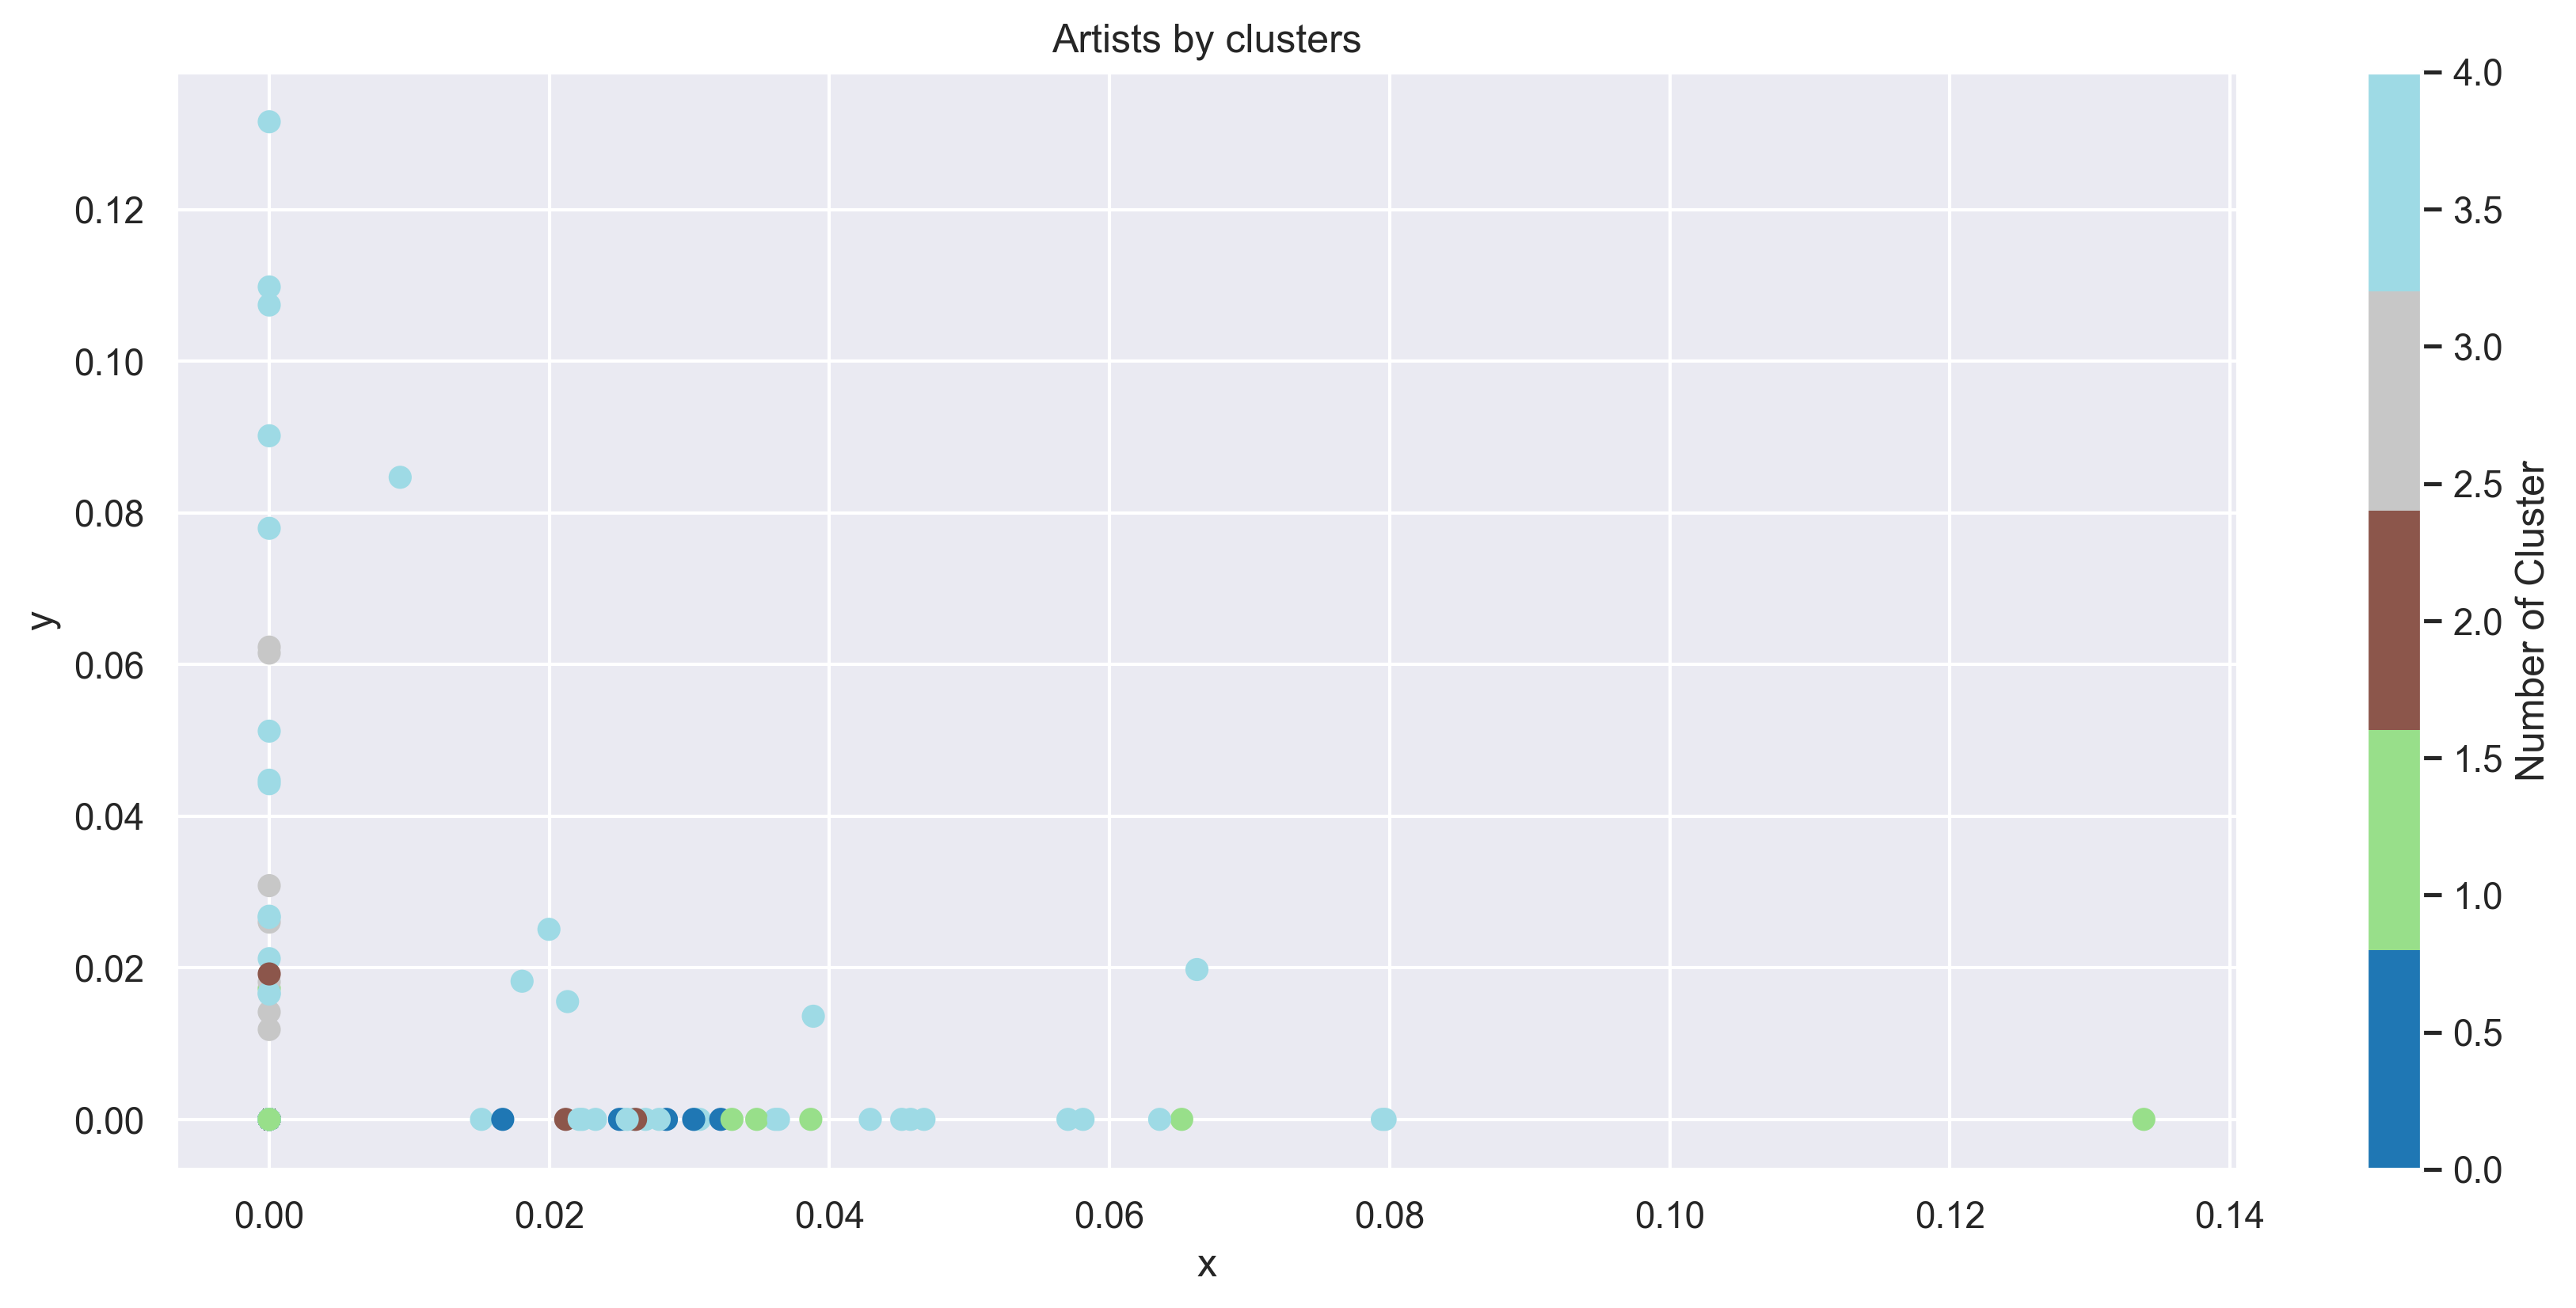

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6), dpi=300)
plt.scatter(
    x=ratings_normalized[0],
    y=ratings_normalized[1],
    c=clusters,
    cmap=plt.get_cmap('tab20', 5),
)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Artists by clusters')
plt.colorbar(label='Number of Cluster')
plt.grid(True)
plt.show()

Получилось плохо интерпретируемая визуализация, потому что данных очень много, а осей лишь 2, из-за этого график получился нечитабельным.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

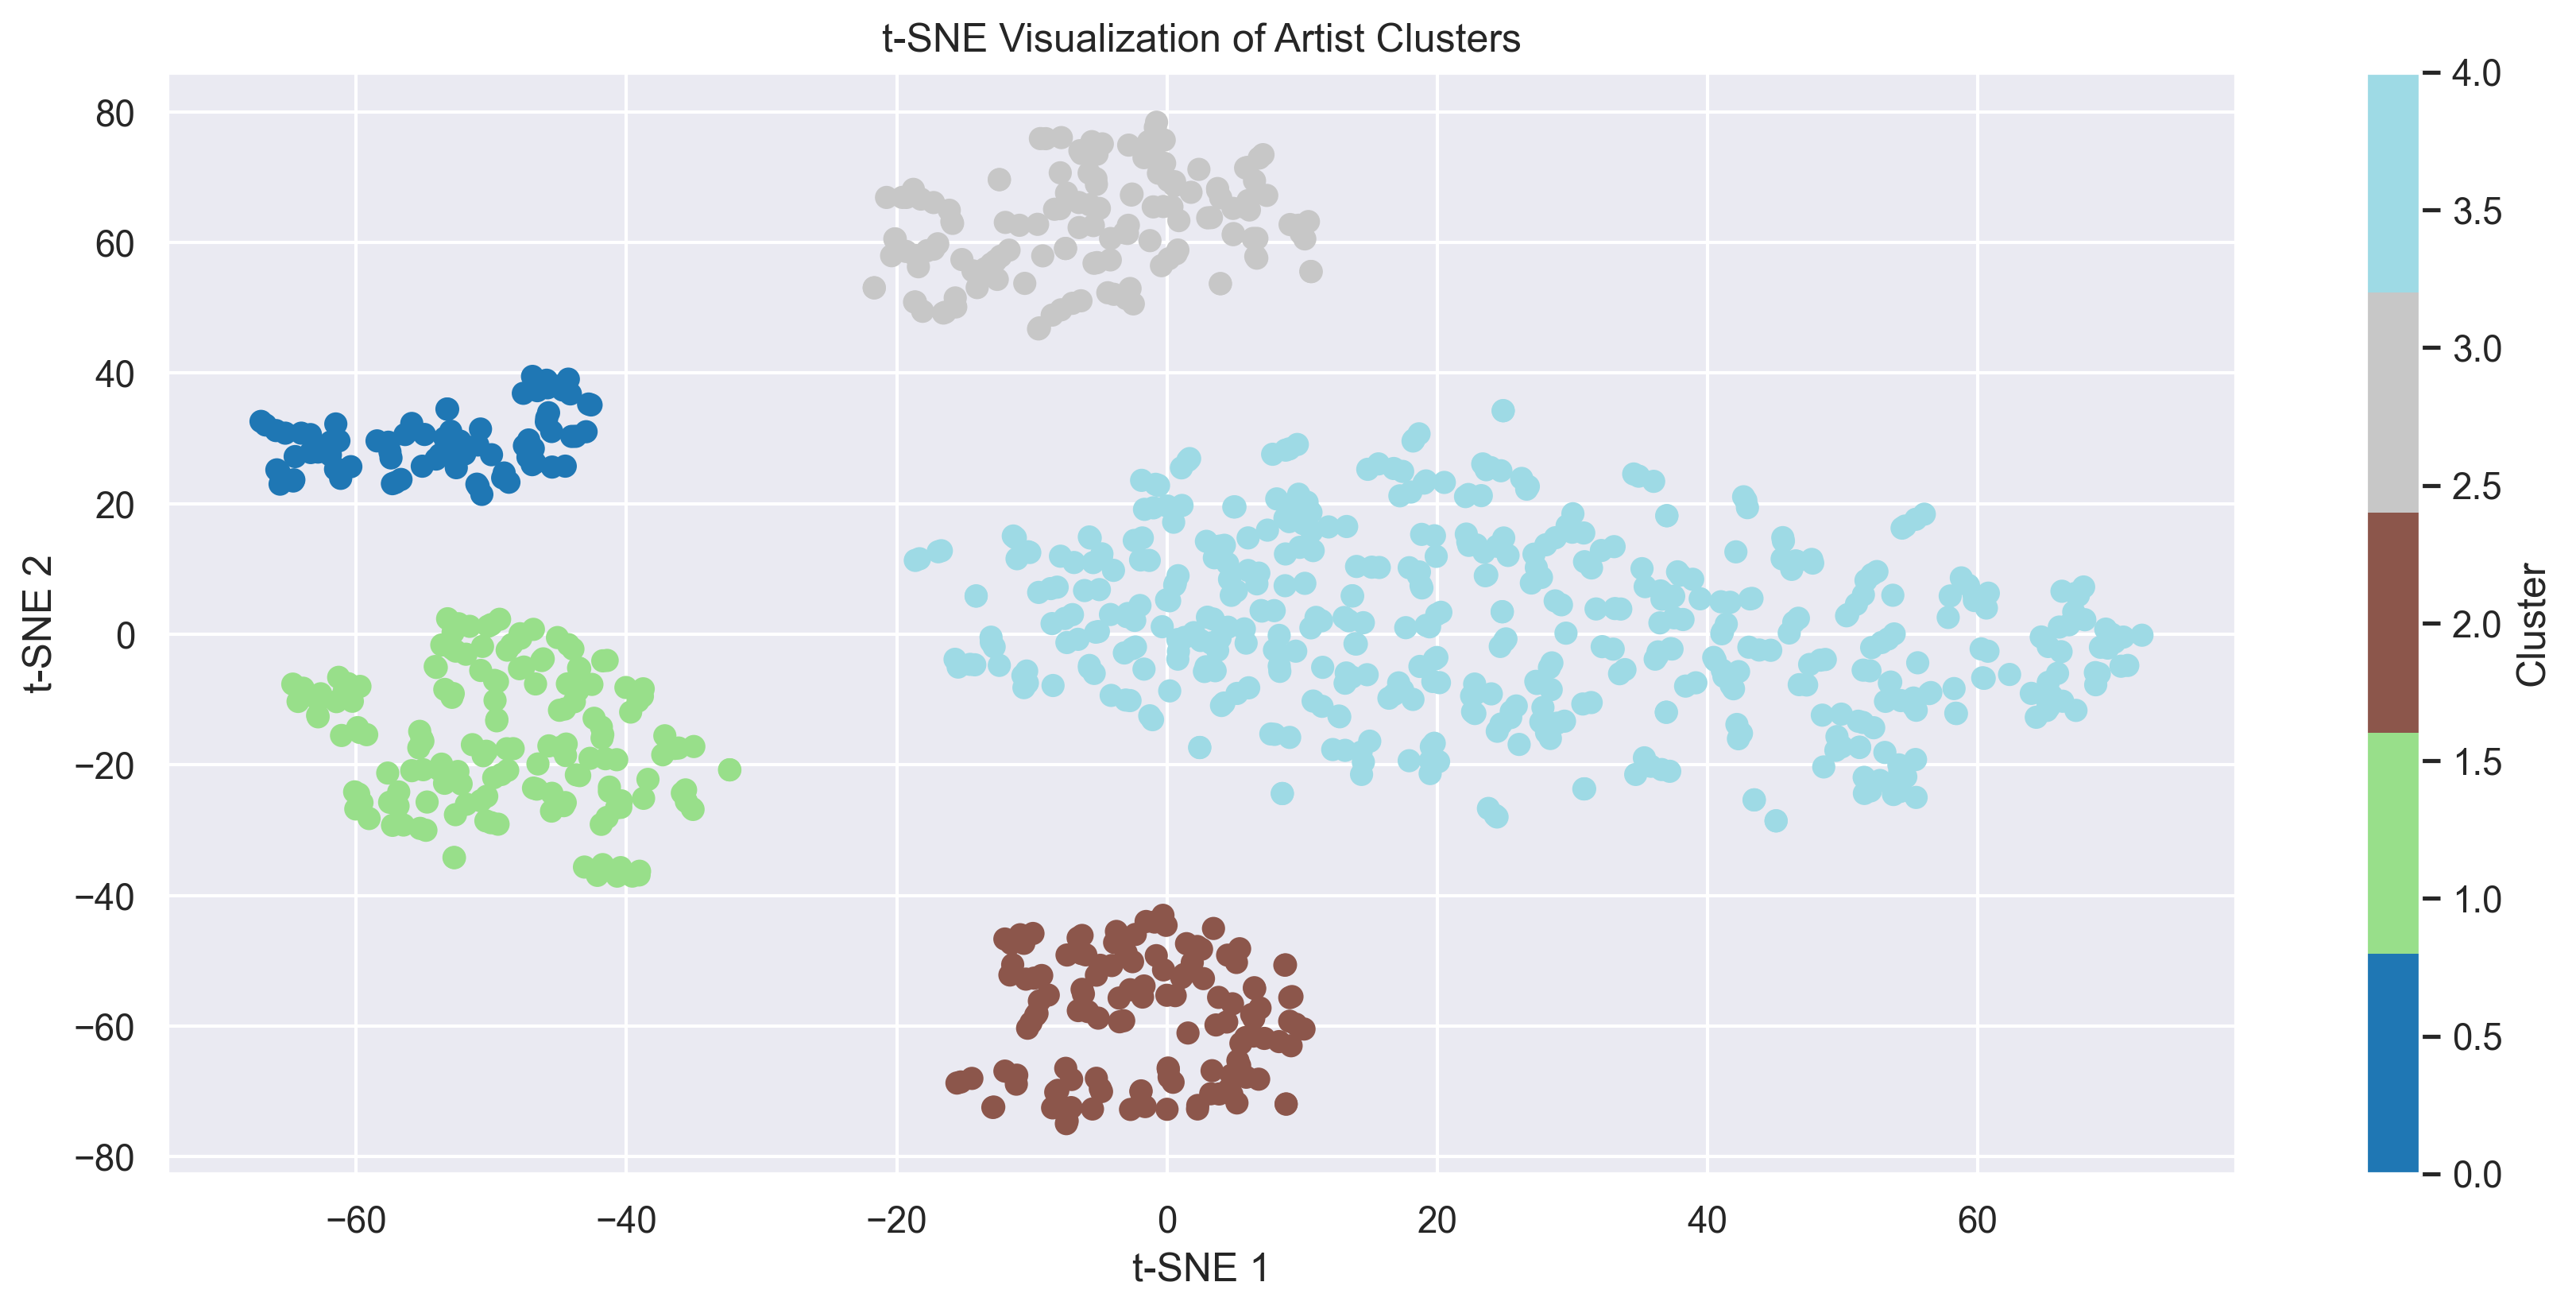

In [184]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(ratings_normalized.values)

tsne_df = pd.DataFrame(tsne_result, columns=["TSNE 1", "TSNE 2"])
tsne_df["cluster"] = ratings_normalized["cluster"].values

plt.figure(figsize=(14, 6), dpi=300)
scatter = plt.scatter(
    tsne_df['TSNE 1'],
    tsne_df['TSNE 2'],
    c=tsne_df["cluster"],
    cmap=plt.get_cmap('tab20', 5),
)
plt.title('t-SNE Visualization of Artist Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

Best number of clusters is: 98


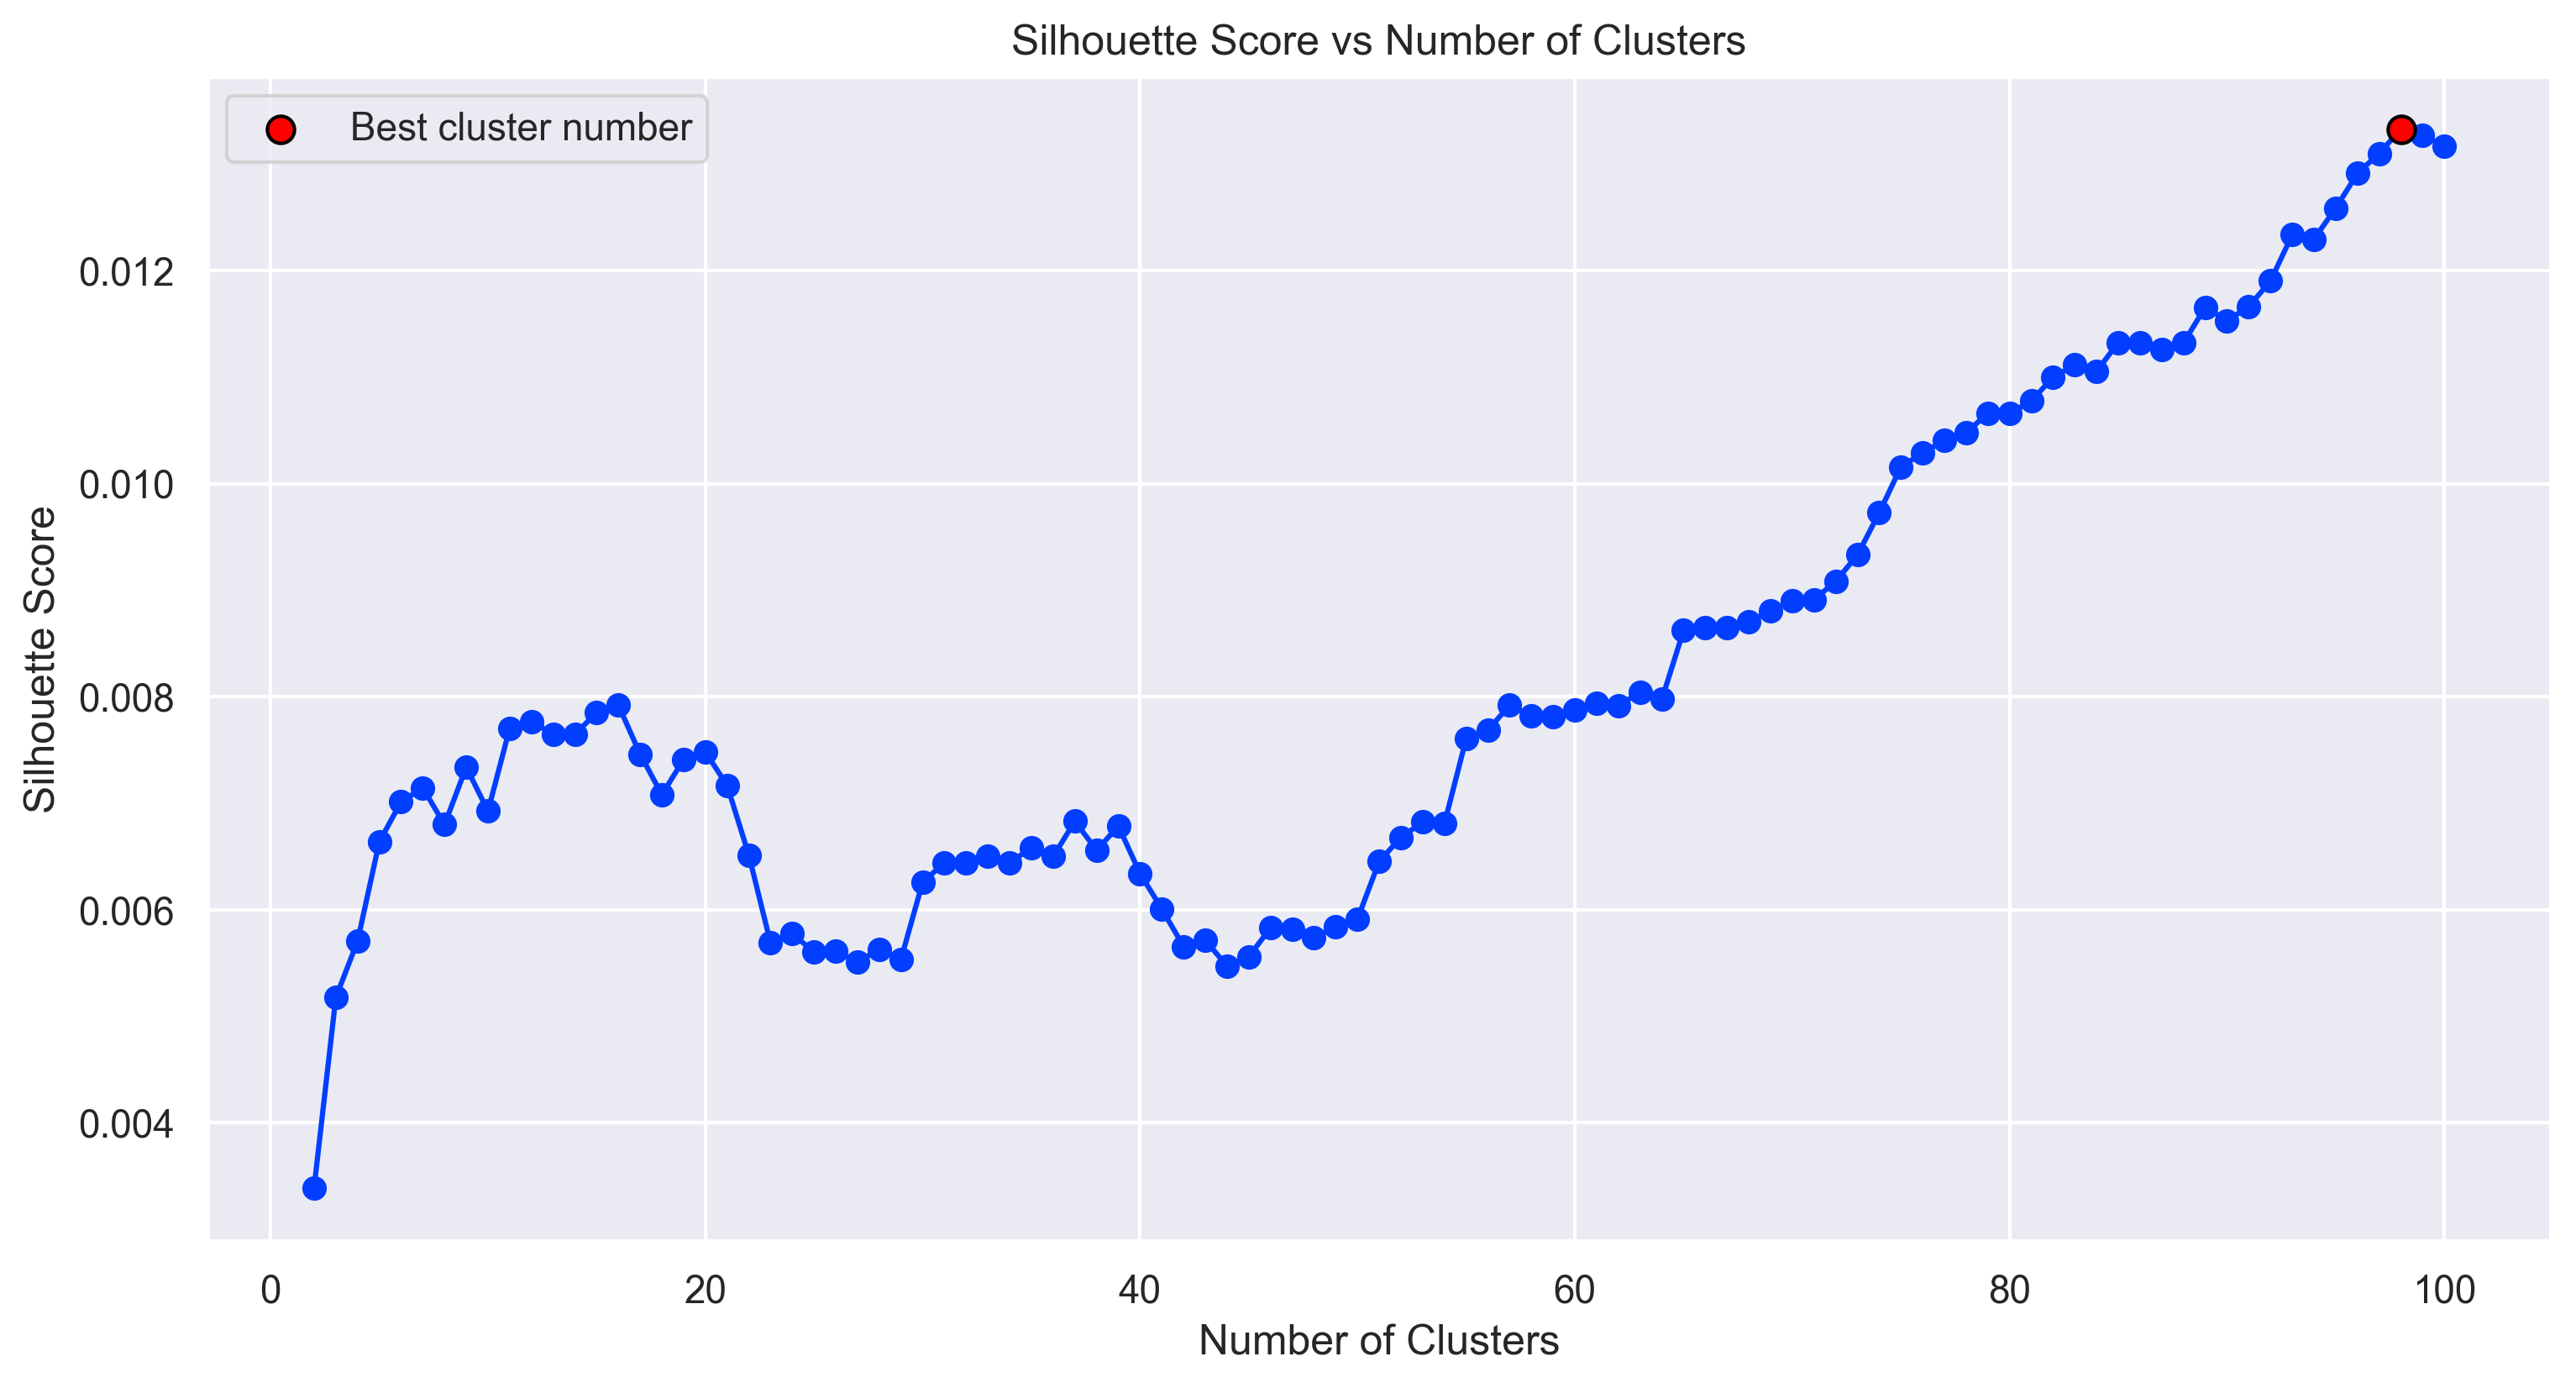

In [189]:
from sklearn.metrics import silhouette_score

n_clusters_values = np.arange(2, 101, 1)

silhouette_scores = []

for n_clusters in n_clusters_values:
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(ratings_normalized.drop(columns=["cluster"]))

    score = silhouette_score(ratings_normalized.drop(columns=["cluster"]), clusters)
    silhouette_scores.append(score)

best_index = np.argmax(silhouette_scores)
best_n_clusters = n_clusters_values[best_index]
best_score = silhouette_scores[best_index]
print(f"Best number of clusters is: {best_n_clusters}")

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(n_clusters_values, silhouette_scores, marker='o')
plt.scatter(
    x=[best_n_clusters], 
    y=[best_score], 
    label="Best cluster number",
    c='red',
    edgecolors='black',
    s=60,
    zorder=5
)
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [190]:
ratings_normalized = ratings_normalized.drop(columns=["cluster"])

model = KMeans(n_clusters=best_n_clusters, random_state=42)
model.fit(ratings_normalized)
clusters = model.predict(ratings_normalized)

ratings_normalized["cluster"] = clusters

cluster_sizes = ratings_normalized["cluster"].value_counts().sort_index()

centroids = model.cluster_centers_

for cluster in range(len(cluster_sizes)):
    cluster_artists = ratings_normalized.index[model.labels_ == cluster]

    cluster_vector = ratings_normalized.drop(columns=["cluster"]).loc[cluster_artists]

    centroid = centroids[cluster]

    distances = cluster_vector.apply(lambda row: cosine(row, centroid), axis=1)

    top_artists = distances.nsmallest(10).index.to_list()

    print(f"\nTop 10 artist for cluster {cluster}:")
    for i, artist in enumerate(top_artists):
        print(f"{i + 1}. {artist}")


Top 10 artist for cluster 0:
1. dr. dre
2. the faint
3. violent femmes
4. margot and the nuclear so and sos
5. owen
6. the bloodhound gang

Top 10 artist for cluster 1:
1. john mayer
2. matt nathanson
3. gavin degraw
4. jason mraz
5. ray lamontagne
6. joshua radin
7. sara bareilles
8. augustana
9. maroon5
10. o.a.r.

Top 10 artist for cluster 2:
1. white stripes
2. beck
3. the raconteurs
4. spoon
5. the pixies
6. the strokes
7. the flaming lips
8. cake
9. black rebel motorcycle club
10. gorillaz

Top 10 artist for cluster 3:
1. fugazi
2. jawbreaker
3. sleater-kinney
4. les savy fav
5. capn jazz
6. bad brains
7. blonde redhead
8. propagandhi
9. the melvins
10. gogol bordello

Top 10 artist for cluster 4:
1. ryan adams
2. band of horses
3. ryan adams and the cardinals
4. rogue wave
5. my morning jacket
6. matt pond pa
7. cloud cult
8. the american analog set
9. nada surf
10. tv on the radio

Top 10 artist for cluster 5:
1. dj shadow
2. rjd2
3. amon tobin
4. jedi mind tricks
5. el-p
6. a

**Ответ:** Теперь выборка разделилась на 98 кластера. Смысл остался примерно тем же, но с более явным разделением на жанры.

Из интересного - есть кластер номер 38 с женской поп-музыкой, который содержит аристов: Lady Gaga, Britney Spears, Pink, Madonna, Shakira.

Также есть кластер 28 с рэпом: Eminem, 50 cent, Tupak.

Сделайте t-SNE визуализацию полученной кластеризации.

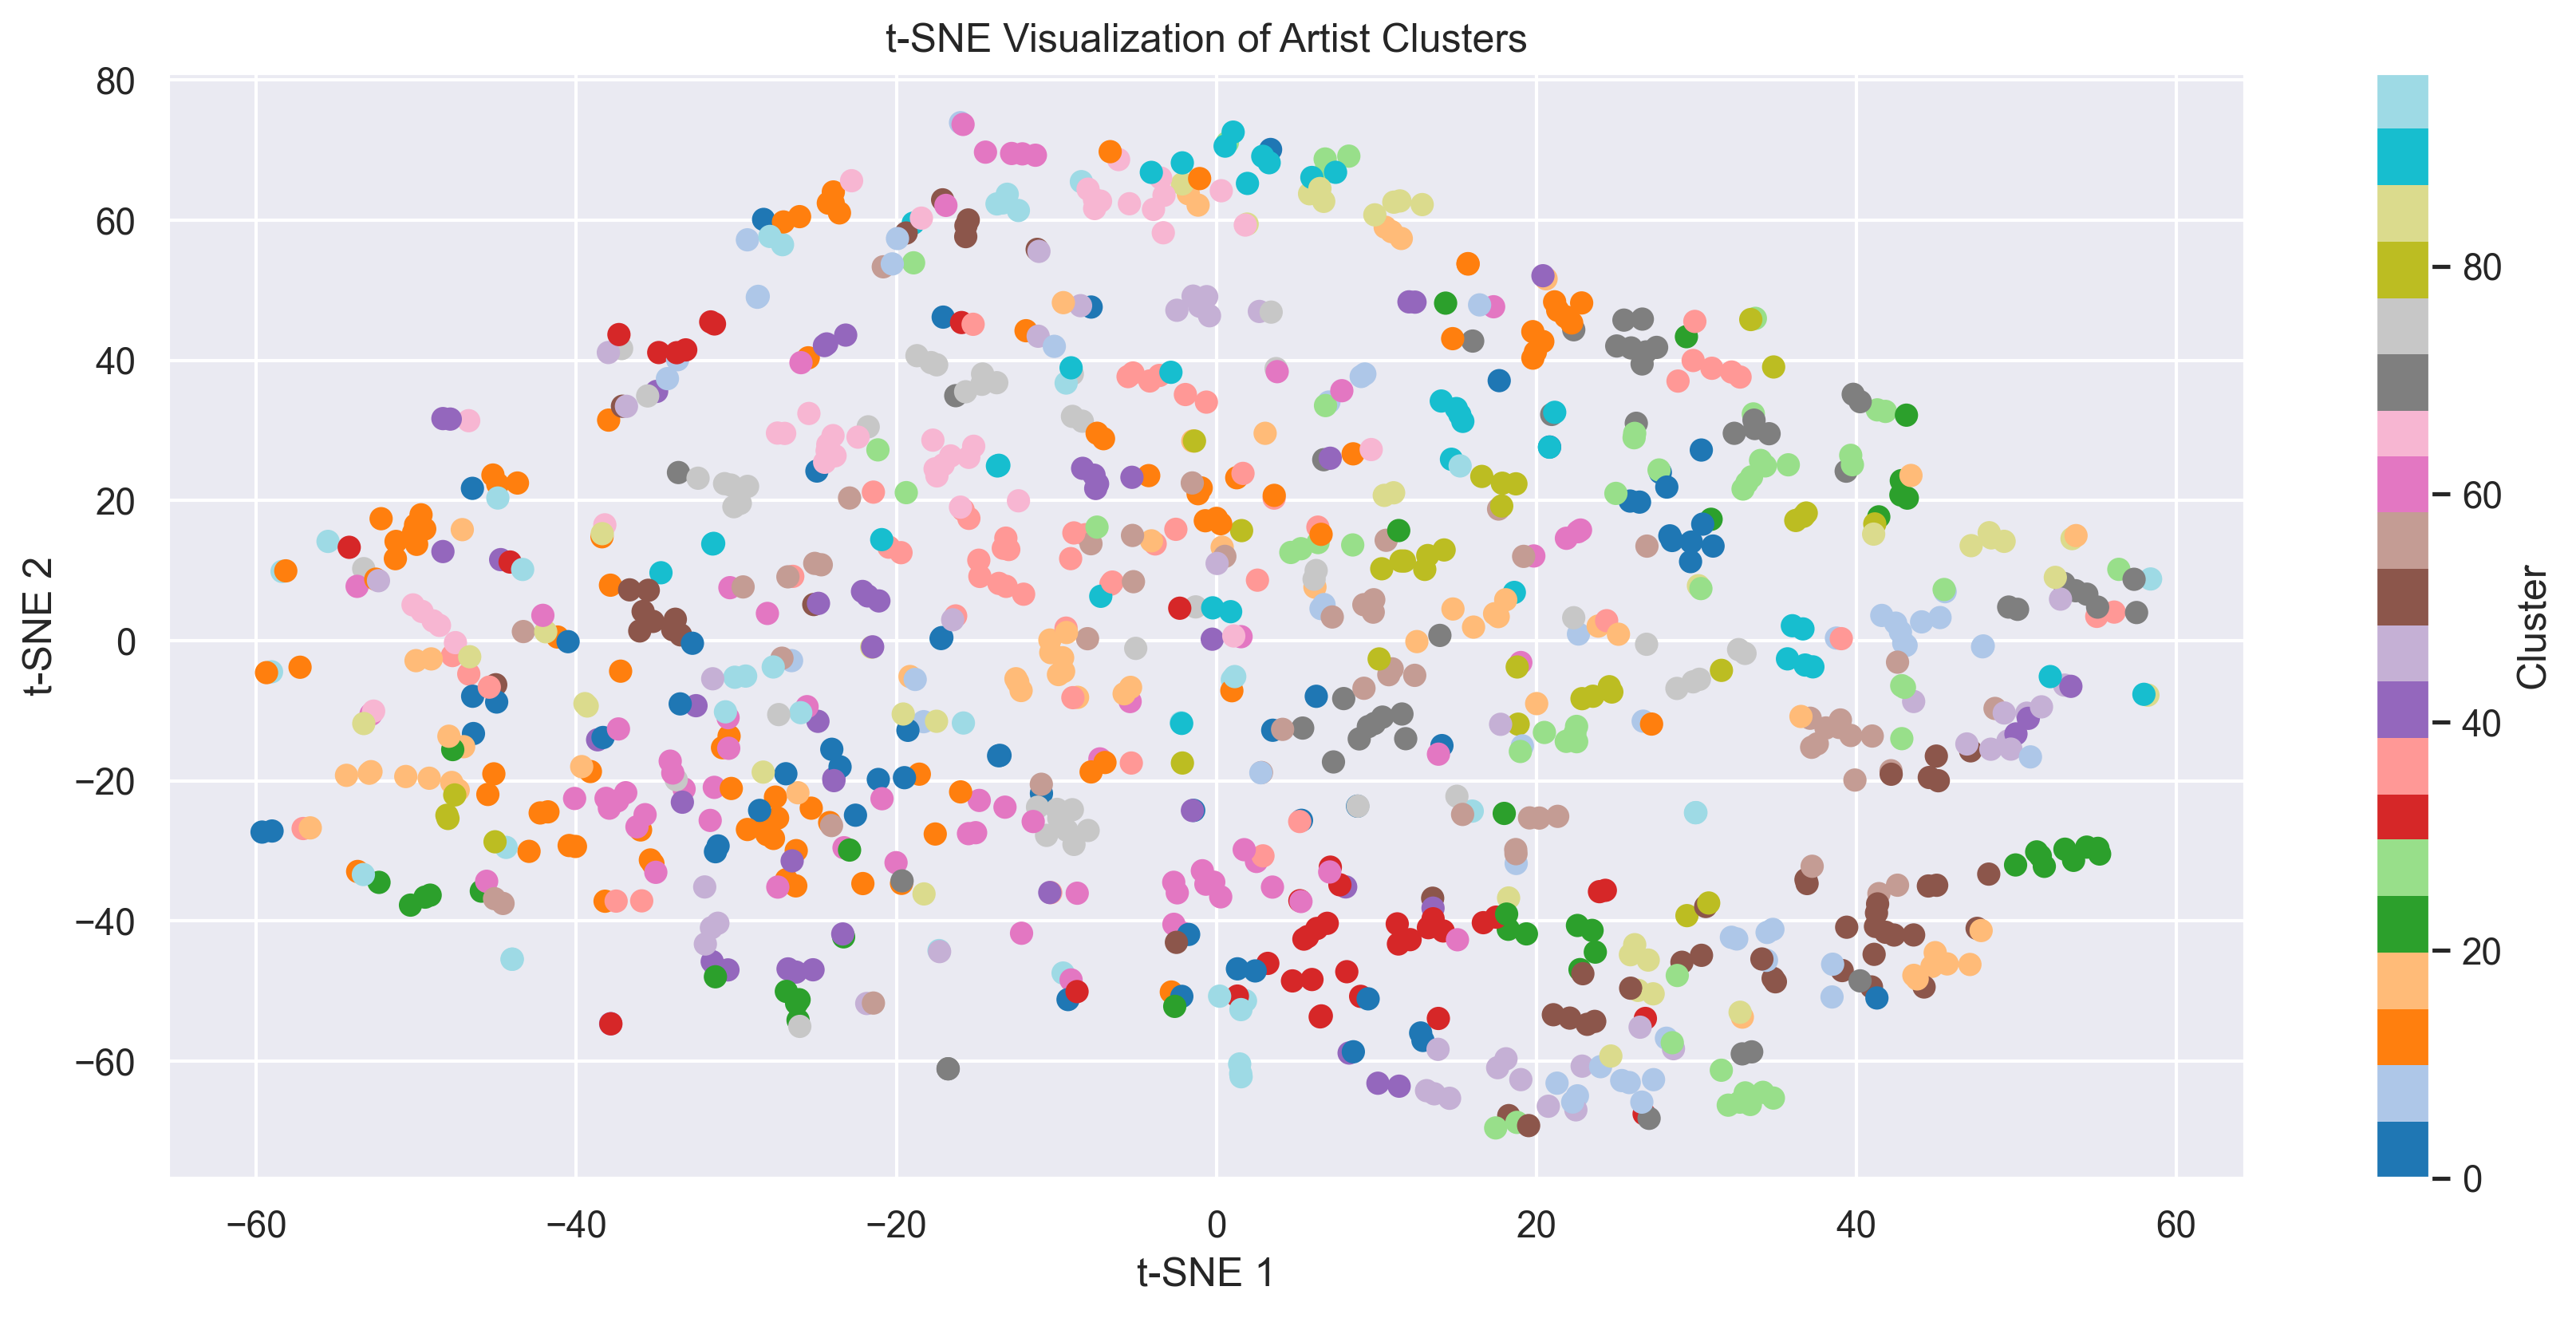

In [191]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(ratings_normalized.drop(columns=["cluster"]))

tsne_df = pd.DataFrame(tsne_result, columns=["TSNE 1", "TSNE 2"])
tsne_df["cluster"] = ratings_normalized["cluster"].values

plt.figure(figsize=(14, 6), dpi=300)
scatter = plt.scatter(
    tsne_df['TSNE 1'],
    tsne_df['TSNE 2'],
    c=tsne_df["cluster"],
    cmap=plt.get_cmap('tab20', best_n_clusters),
)
plt.title('t-SNE Visualization of Artist Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

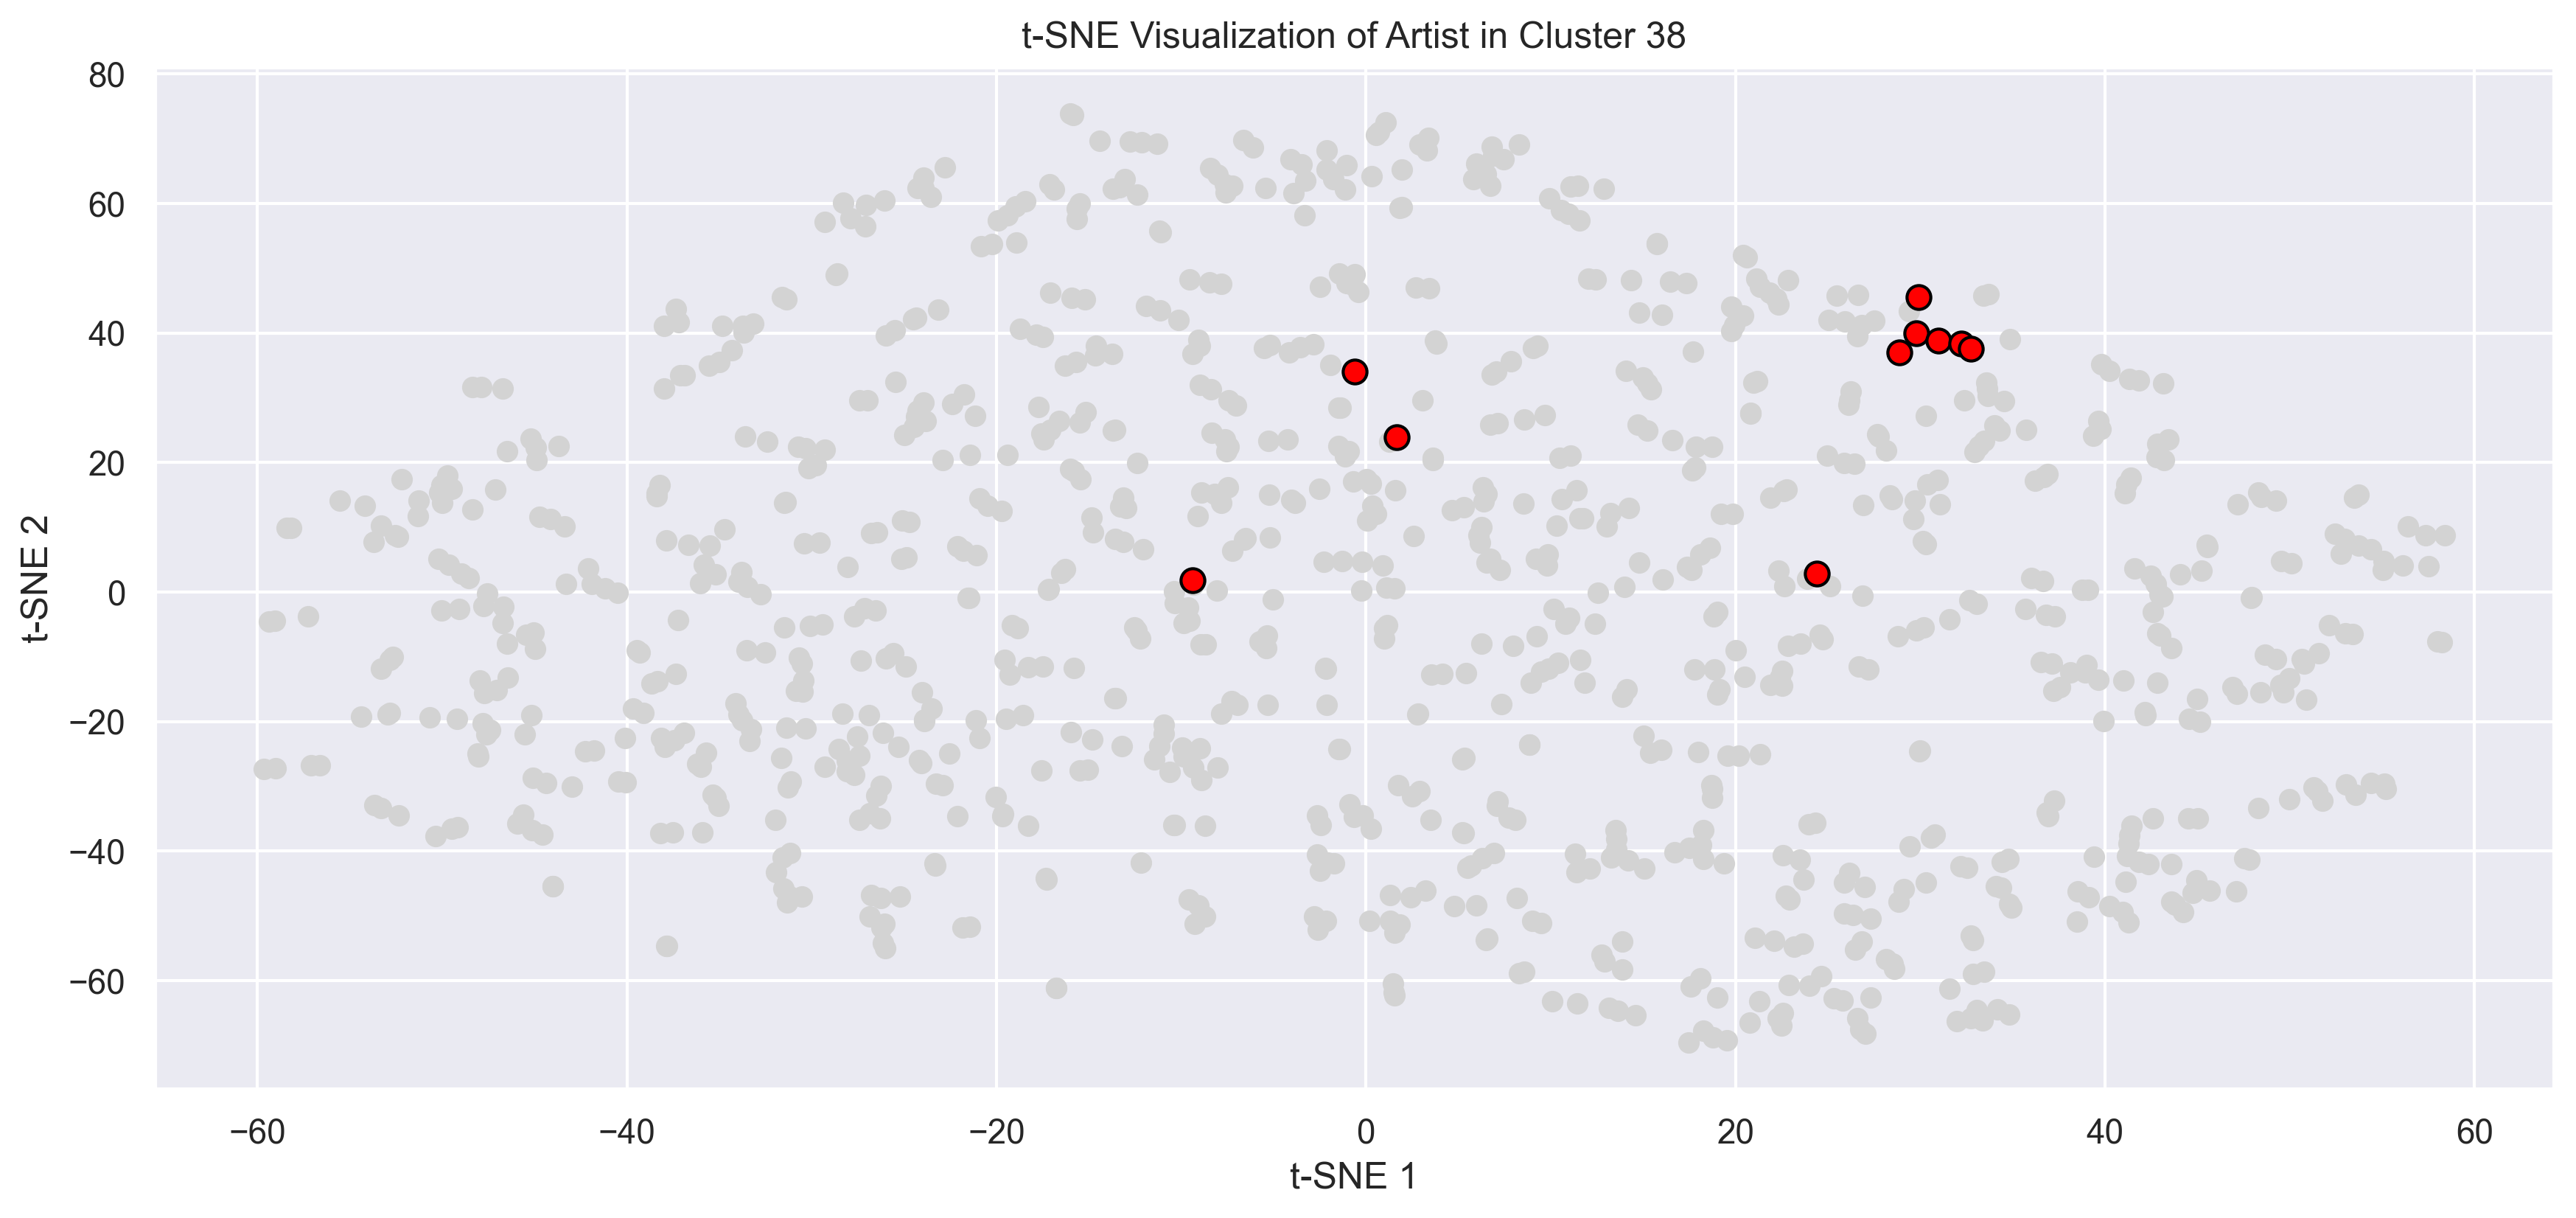

In [192]:
interesting_cluster = 38

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(ratings_normalized.drop(columns=["cluster"]))

tsne_df = pd.DataFrame(tsne_result, columns=["TSNE 1", "TSNE 2"])
tsne_df["cluster"] = ratings_normalized["cluster"].values

plt.figure(figsize=(14, 6), dpi=300)
plt.scatter(
    tsne_df['TSNE 1'],
    tsne_df['TSNE 2'],
    c='lightgray',
    label='other clusters'
)
plt.scatter(
    tsne_df.loc[tsne_df["cluster"] == interesting_cluster, "TSNE 1"],
    tsne_df.loc[tsne_df["cluster"] == interesting_cluster, "TSNE 2"],
    c="red",
    label=f"Cluster {interesting_cluster}",
    edgecolors="black",
    s=60
)
plt.title(f't-SNE Visualization of Artist in Cluster {interesting_cluster}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()

**Ответ:** Выделили кластер 38, содержащий поп-музыку. Визуально бОльшая часть артистов расположены рядом. Кроме того, есть 4 выброса, которые достаточно далековато расположены.

<img src="https://raw.githubusercontent.com/vasyukov1/HSE-FCS-SE-2-year/refs/heads/main/IAD/homeworks/hw08-boosting-clustering/meme.jpg" alt="meme" style="width: 700px;"/>